In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import MySQLdb as mdb
# from definitions import DATABASE_CONFIG_DIR, INCOME_STATEMENT_DIR

## load stock info

In [3]:
with open('../../database/database_config/database.ymal') as f:
    db_config = yaml.load(f, Loader=yaml.FullLoader)
db = mdb.connect(host=db_config['db_host'], user=db_config['db_user'], passwd=db_config['db_pass'],
                 db=db_config['db_name'], use_unicode=True, charset="utf8")
# select stockId and ticker from table stock_info
table_name = 'stock_info'
column_list = ['stockId', 'ticker', 'IndustryGroup']
columns = ','.join(column_list)
req = """SELECT %s FROM %s WHERE sp500=TRUE """ % (columns, table_name)
get_stock_info_cursor = db.cursor()
get_stock_info_cursor.execute(req)
stock_info = get_stock_info_cursor.fetchall()
get_stock_info_cursor.close()

#create dataframe
df_stock_info = pd.DataFrame(stock_info, columns=column_list)

ProgrammingError: (1146, "Table 'securities_database.stock_info' doesn't exist")

In [3]:
df_stock_info.head(5)

,stockId,ticker,IndustryGroup
0,11,PNR,Machinery
1,37,ALLE,Building Materials
2,45,ITW,Machinery
3,48,AMAT,Semiconductor Equip
4,52,NWL,Household Products


## load the file

In [4]:
file = '../20210828_valuation_result_sp500.csv'
df_valuation = pd.read_csv(file)

In [5]:
df_valuation.head(5)

,ticker,current_price,estimated_value,price_to_value
0,PNR,76.69,37.643159,2.037289
1,ALLE,141.49,87.640388,1.614438
2,ITW,230.64,91.887108,2.510037
3,AMAT,136.55,139.958451,0.975647
4,NWL,25.54,9.927893,2.572550


In [6]:
df_valuation.describe()

,current_price,estimated_value,price_to_value
count,460.000000,458.000000,458.000000
mean,192.271391,80.922087,0.720777
std,347.075202,336.279612,26.042080
min,11.970000,-356.345811,-443.459030
25%,60.102500,4.351935,0.521729
50%,115.830000,38.858909,1.750660
75%,209.320000,90.551223,3.422385
max,5139.270000,6009.795201,136.805041


## merge two dataframes

In [7]:
df = pd.merge(df_valuation, df_stock_info, left_on='ticker', right_on='ticker', how='left')

In [8]:
## filter out finanace sector 
df = df.loc[(df['IndustryGroup']!='Financial Svcs. (Non-bank & Insurance)')
                 & (df['IndustryGroup']!='Banks (Regional)') 
                 & (df['IndustryGroup']!='Bank (Money Center)') 
                 & (df['IndustryGroup']!='Brokerage & Investment Banking') 
                 & (df['IndustryGroup']!='Investments & Asset Management') 
                 & (df['IndustryGroup']!='Insurance (Life)')
                 & (df['IndustryGroup']!='Insurance (Prop/Cas.)')
                 & (df['IndustryGroup']!='Insurance (General)')]

## EDA

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

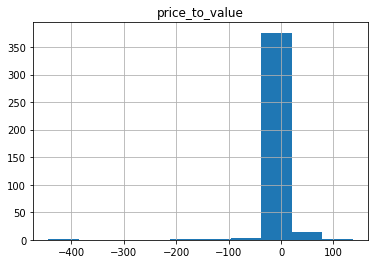

In [9]:
df.hist(column="price_to_value")

### calculate the range

In [10]:
def cut_to(x):
    if x<0:
        return 'less than 0'
    elif x<1:
        return '0-1'
    else:
        return 'larger than 1'

df['valuation_range'] = df['price_to_value'].map(cut_to)

In [11]:
df

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
0,PNR,76.69,37.643159,2.037289,11,Machinery,larger than 1
1,ALLE,141.49,87.640388,1.614438,37,Building Materials,larger than 1
2,ITW,230.64,91.887108,2.510037,45,Machinery,larger than 1
3,AMAT,136.55,139.958451,0.975647,48,Semiconductor Equip,0-1
4,NWL,25.54,9.927893,2.572550,52,Household Products,larger than 1
...,...,...,...,...,...,...,...
500,UAL,47.71,-56.970543,-0.837450,9772,Air Transport,less than 0
501,CDW,199.25,111.952869,1.779767,9829,Computer Services,larger than 1
502,MU,74.00,123.149675,0.600895,9839,Semiconductor,0-1
503,DLTR,90.89,52.678832,1.725361,9850,Retail (General),larger than 1


In [12]:
df['valuation_range'].value_counts()

larger than 1    315
less than 0       98
0-1               30
Name: valuation_range, dtype: int64

## sort

In [13]:
df.sort_values(by=['price_to_value'])

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
477,TFX,388.22,-0.875436,-443.459030,9391,Healthcare Products,less than 0
5,MAA,189.21,-1.065426,-177.590996,54,R.E.I.T.,less than 0
307,BIO,792.41,-7.346978,-107.855230,5711,Heathcare Information and Technology,less than 0
78,NI,24.82,-0.271815,-91.312220,1509,Utility (General),less than 0
169,ZBH,150.07,-2.434665,-61.638879,3210,Healthcare Products,less than 0
...,...,...,...,...,...,...,...
415,MXIM,NaN,NaN,NaN,7952,Semiconductor,larger than 1
435,APD,NaN,NaN,NaN,8378,Chemical (Specialty),larger than 1
438,ACN,NaN,NaN,NaN,8431,Computer Services,larger than 1
456,CBOE,NaN,NaN,NaN,8855,empty,larger than 1


### select the valuation between 0-1

In [14]:
df = df.loc[df['valuation_range'] == '0-1']
df = df.sort_values(by=['price_to_value'])

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

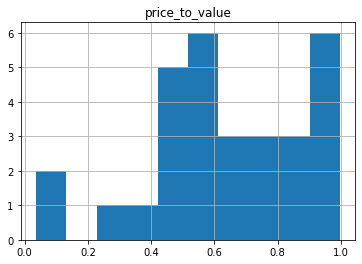

In [15]:
df.hist(column="price_to_value")

In [16]:
df.head(10)

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
23,CI,210.68,6009.795201,0.035056,344,Healthcare Support Services,0-1
479,DXC,37.35,552.309101,0.067625,9425,Computer Services,0-1
96,FANG,76.65,240.945501,0.318122,1764,Oil/Gas (Production and Exploration),0-1
26,CNC,63.98,174.584305,0.366471,375,Healthcare Support Services,0-1
133,TSN,78.51,163.072354,0.481443,2473,Food Processing,0-1
132,CAH,51.74,104.727727,0.494043,2448,Healthcare Support Services,0-1
356,WBA,48.48,98.038753,0.494498,6569,Retail (Special Lines),0-1
140,ABC,119.89,236.278563,0.507410,2669,Healthcare Support Services,0-1
53,PHM,54.88,106.503215,0.515290,1120,Homebuilding,0-1
35,HII,206.99,382.572232,0.541048,680,Aerospace/Defense,0-1


In [17]:
df.loc[(df['price_to_value']>0.1) & (df['price_to_value']<0.8)]

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
96,FANG,76.65,240.945501,0.318122,1764,Oil/Gas (Production and Exploration),0-1
26,CNC,63.98,174.584305,0.366471,375,Healthcare Support Services,0-1
133,TSN,78.51,163.072354,0.481443,2473,Food Processing,0-1
132,CAH,51.74,104.727727,0.494043,2448,Healthcare Support Services,0-1
356,WBA,48.48,98.038753,0.494498,6569,Retail (Special Lines),0-1
140,ABC,119.89,236.278563,0.507410,2669,Healthcare Support Services,0-1
53,PHM,54.88,106.503215,0.515290,1120,Homebuilding,0-1
35,HII,206.99,382.572232,0.541048,680,Aerospace/Defense,0-1
194,LEN,107.96,197.275010,0.547256,3614,Homebuilding,0-1
97,HPQ,28.92,52.408186,0.551822,1784,Computers/Peripherals,0-1
